In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot') #Make the graphs pretty :) 

In [6]:
#Load data:

df = pd.DataFrame.from_csv('sonar.all-data',index_col=None)
#Create columns list. EB stands for Energy band
cols = ['EB'+str(i) for i in range(1,len(df.columns))] + ['Class']
df.columns = cols

# Part B. data description:


The data contains patterns of sonar projected upon cylindircal rocks, and cylndrical metal objects.
The data includes 207 samples, and 60 features. Each feature represents the energy in a different energy band, each row represents a different experiment (measurement - the sonar returned from the object). The data also includes the class (rock vs metal) for each experiment.

In [7]:
#General stats of the data:
df.describe().loc[['mean','std','max']]


,EB1,EB2,EB3,EB4,EB5,EB6,EB7,EB8,EB9,EB10,...,EB51,EB52,EB53,EB54,EB55,EB56,EB57,EB58,EB59,EB60
mean,0.029208,0.038443,0.043837,0.054053,0.075105,0.104599,0.121591,0.134677,0.177361,0.208245,...,0.016034,0.013472,0.010729,0.010917,0.009300,0.008181,0.007771,0.007947,0.007936,0.006523
std,0.023038,0.033040,0.038521,0.046583,0.055669,0.059247,0.061897,0.085340,0.118311,0.134741,...,0.012027,0.009628,0.007071,0.007310,0.007103,0.005719,0.005756,0.006485,0.006196,0.005038
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


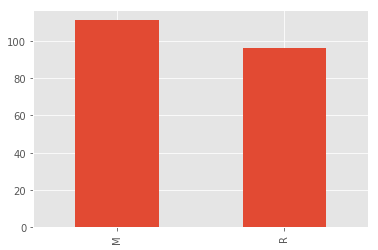

In [9]:
#Labels distribution
sr = df['Class']

sr.value_counts().plot(kind='bar')
